In [90]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from torch.utils.data import Dataset, DataLoader


device = torch.device("cpu") #Use CPU
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #If nvidea GPU is available use GPU
device

device(type='cpu')

In [91]:

class TitanicDataset(Dataset):
    def __init__(self, file_path: str, train:bool=True):
        """
        Arguments:
            file_path (string): Path to the csv file with annotations.
            train (bool): Return training data if True, else return test data.
        """
    
        df = pd.read_csv(file_path)
        
        # Choose features
        self.features = ["Pclass", "Age", "SibSp", "Parch", "Fare", "Sex", "Embarked"]
        df = df[self.features + ["Survived"]].dropna()
        
        # One-Hot-Encoding
        df = pd.get_dummies(df, columns=["Sex", "Embarked"], drop_first=True)
        
        # Skaling of numerical features
        scaler = StandardScaler()
        numerical_features = ["Pclass", "Age", "SibSp", "Parch", "Fare"]
        df[numerical_features] = scaler.fit_transform(df[numerical_features])
        
        # Set data and target
        self.X = df.drop(columns=["Survived"], axis=1).values.astype(np.float32)
        self.y = df["Survived"].values.astype(np.float32).reshape(-1, 1)
        
        # Split data into training and testing sets
        split_idx = int(0.8 * len(df))
        if train:
            self.X, self.y = self.X[:split_idx], self.y[:split_idx]
        else:
            self.X, self.y = self.X[split_idx:], self.y[split_idx:]
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])

In [92]:
# Initialize dataset
titanic_train = TitanicDataset("titanic.csv", train=True)
titanic_val = TitanicDataset("titanic.csv", train=False)

train_loader = DataLoader(titanic_train, batch_size=16, shuffle=True)
test_loader = DataLoader(titanic_val, batch_size=16, shuffle=False)

batch_size_train = 16
batch_size_test = 16
n_epoch = 50

In [93]:
class TitanicNN(torch.nn.Module):
    def __init__(self, D_in, hidden_layers, D_out):
        """
        Arguments:
            D_in (int): Input dimension.
            hidden_layers (list): List of integers representing the size of each hidden layer.
            D_out (int): Output dimension.
        """
        super(TitanicNN, self).__init__()
        layers = []
        input_size = D_in
        
        # Create hidden layers
        for hidden_size in hidden_layers:
            layers.append(torch.nn.Linear(input_size, hidden_size))
            layers.append(torch.nn.ReLU())
            input_size = hidden_size
        
        # Add output layer
        layers.append(torch.nn.Linear(input_size, D_out))
        layers.append(torch.nn.Sigmoid())
        
        # Combine all layers into a sequential model
        self.model = torch.nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [94]:
D_in, D_out = titanic_train.X.shape[1], 1
loss_fn = torch.nn.BCELoss()


In [95]:
def test(model, test_accuracies):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            output = model(batch_X)
            pred = (output >= 0.5).float()
            correct += (pred == batch_y).sum().item()
            total += batch_y.size(0)
    accuracy = correct / total
    test_accuracies.append(accuracy)


In [ ]:
def train(model, train_accuracies, test_accuracies, optimizer):
  for current_epoch in range(n_epoch):
    model.train()
    correct = 0
    total = 0
    for batch_idx, (batch_data, batch_labels) in enumerate(train_loader):
      # Forward pass: Compute predicted y by passing x to the model
      batch_data = batch_data.to(device)
      batch_labels = batch_labels.to(device)
      y_pred = model(batch_data)

      # Compute loss
      loss = loss_fn(y_pred, batch_labels)

      # Zero gradients, perform a backward pass, and update the weights
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Calculate predictions and update correct/total counts
      pred = (y_pred >= 0.5).float()
      correct += (pred == batch_labels).sum().item()
      total += batch_labels.size(0)

    # Calculate and save accuracy for the epoch
    epoch_accuracy = correct / total
    train_accuracies.append(epoch_accuracy)

    test(model, test_accuracies)

Testing model with H=[5] and learning_rate=0.001


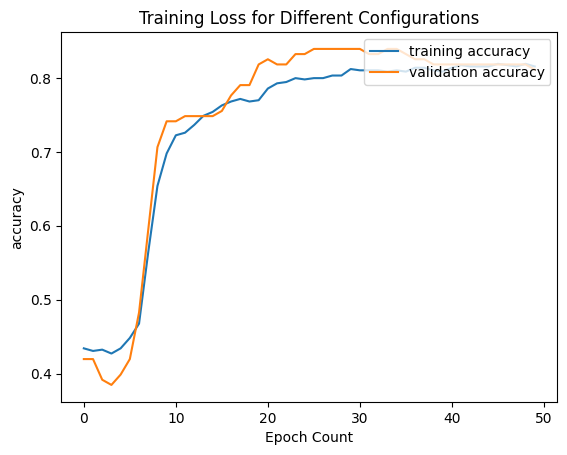

Testing model with H=[10] and learning_rate=0.001


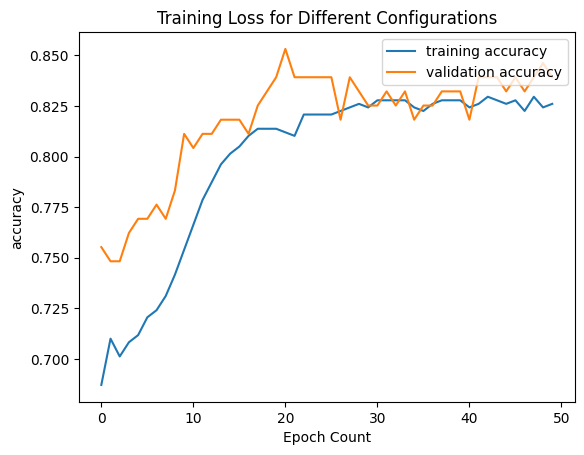

Testing model with H=[15] and learning_rate=0.001


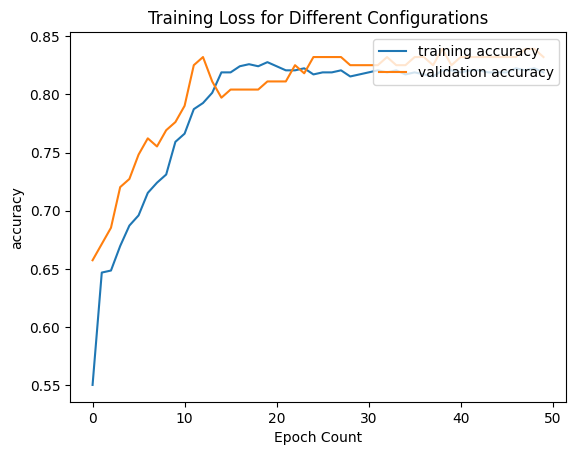

Testing model with H=[15, 50, 15] and learning_rate=0.0001


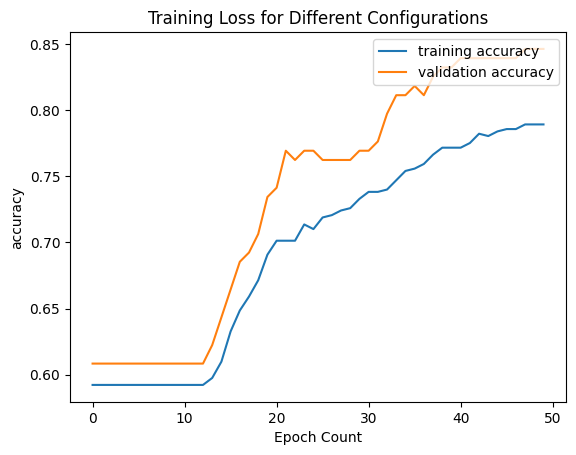

In [97]:
# Define different configurations for the models
model_configs = [
    {"H": [5], "learning_rate": 0.001},
    {"H": [10], "learning_rate": 0.001},
    {"H": [15], "learning_rate": 0.001},
    {"H": [15, 50, 15], "learning_rate": 0.0001},
]
def run_model(model_class):

    # Loop through each configuration
    for config in model_configs:
        print(f"Testing model with H={config['H']} and learning_rate={config['learning_rate']}")
        
        # Initialize model, loss function, and optimizer with the current configuration
        model = model_class(D_in, config["H"], D_out).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])
        train_accuracy, test_accuracy = [], []
        
        # Train the model
        train(model, train_accuracy, test_accuracy, optimizer)

        # Plot all training losses in one figure
        fig = plt.figure()
        plt.plot(train_accuracy, label="training accuracy")
        plt.plot(test_accuracy, label="validation accuracy")
        plt.legend(loc='upper right')
        plt.xlabel('Epoch Count')
        plt.ylabel('accuracy')
        plt.title('Training Loss for Different Configurations')
        plt.show()
run_model(TitanicNN)

In [104]:
class TitaniDropoutcNN(torch.nn.Module):
    def __init__(self, D_in, hidden_layers, D_out, dropout_prob=0.2):
        """
        Arguments:
            D_in (int): Input dimension.
            hidden_layers (list): List of integers representing the size of each hidden layer.
            D_out (int): Output dimension.
            dropout_prob (float): Probability of an element to be zeroed during dropout.
        """
        super(TitaniDropoutcNN, self).__init__()
        layers = []
        input_size = D_in
        
        # Create hidden layers with dropout
        for hidden_size in hidden_layers:
            layers.append(torch.nn.Linear(input_size, hidden_size))
            layers.append(torch.nn.ReLU())
            layers.append(torch.nn.Dropout(p=dropout_prob))
            input_size = hidden_size
        
        # Add output layer
        layers.append(torch.nn.Linear(input_size, D_out))
        layers.append(torch.nn.Sigmoid())
        
        # Combine all layers into a sequential model
        self.model = torch.nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

Testing model with H=[5] and learning_rate=0.001


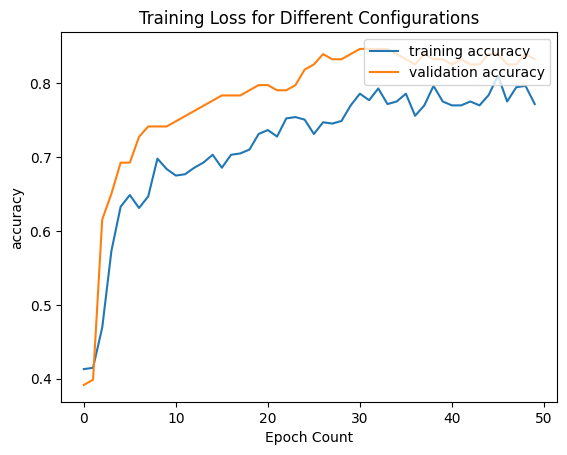

Testing model with H=[10] and learning_rate=0.001


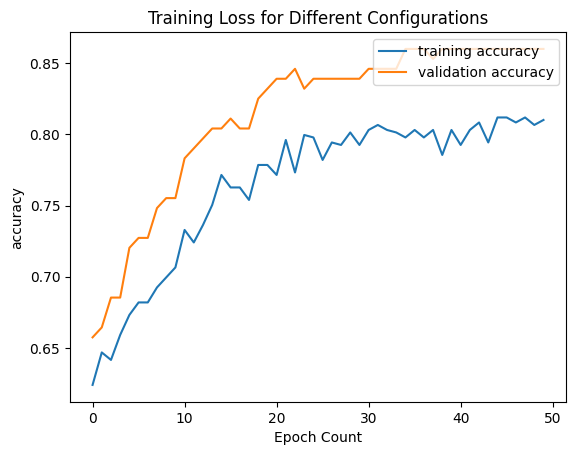

Testing model with H=[15] and learning_rate=0.001


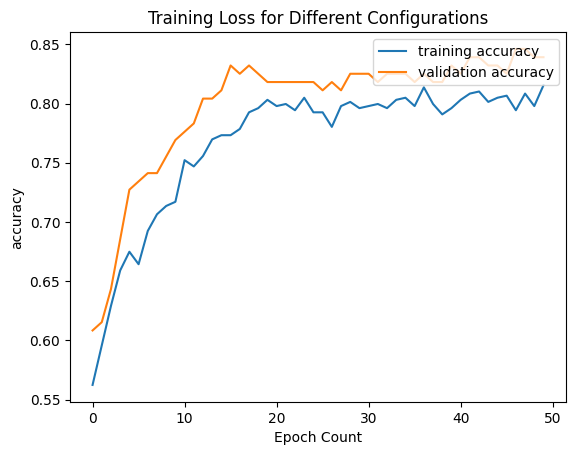

Testing model with H=[15, 50, 15] and learning_rate=0.0001


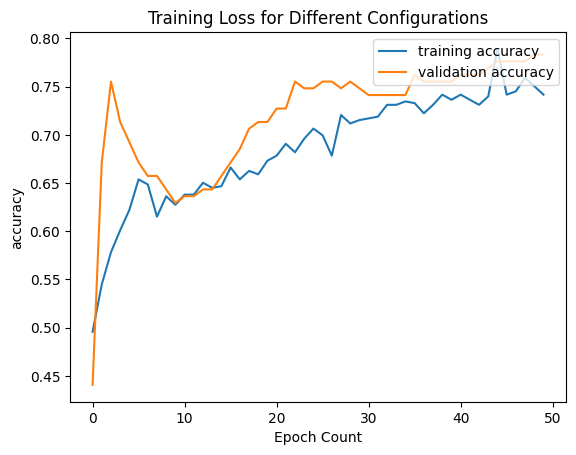

In [105]:
run_model(TitaniDropoutcNN)